# Using Spark to explore the Uber pickups timeseries data

## Import necessary modules

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

In [2]:
# function to select a few rows of data, 
# convert to a Pandas dataframe, and transpose

def preview(df, n=3, sample=False, sample_frac=0.01):
    if sample == True:
        return pd.DataFrame(df.sample(False, sample_frac).take(n), columns=df.columns)
    else:
        return pd.DataFrame(df.take(n), columns=df.columns)

## Open files

### 2014 files

In [6]:
# create list of names of files to open

fp = 'gs://metis_bucket_av/data/uber-tlc-foil-response/uber-trip-data/'
months = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
fn = 'uber-raw-data-{}14.csv'
fns = [fp + fn.format(m) for m in months]

In [7]:
# open each CSV, read in with spark, 
# and join to create one large dataframe

df14 = spark.read.csv(fns[0], header=True)
for f in fns[1:]:
    temp_df = spark.read.csv(f, header=True)
    df14 = df14.union(temp_df)

In [8]:
# check # of rows in resulting final dataframe

num_rows_df14 = df14.count()
print('{:,} rows'.format(num_rows_df14))

4,411,834 rows


In [46]:
preview(df14, 5)

,Date/Time,Lat,Lon,Base,Loc
0,4/1/2014 0:11:00,40.769,-73.9549,B02512,Upper East Side
1,4/1/2014 0:21:00,40.7316,-73.9873,B02512,East Village
2,4/1/2014 0:28:00,40.7588,-73.9776,B02512,Midtown
3,4/1/2014 0:33:00,40.7594,-73.9722,B02512,Midtown
4,4/1/2014 0:39:00,40.7223,-73.9887,B02512,Lower East Side


In [47]:
df14.printSchema()

root
 |-- Date/Time: string (nullable = true)
 |-- Lat: string (nullable = true)
 |-- Lon: string (nullable = true)
 |-- Base: string (nullable = true)
 |-- Loc: string (nullable = true)



### 2015 file

In [3]:
fn = 'gs://metis_bucket_av/data/uber-tlc-foil-response/uber-trip-data/uber-janjune-15-loc.csv'
df15 = spark.read.csv(fn, header=True)

In [4]:
num_rows_df15 = df15.count()
print('{:,} rows'.format(num_rows_df15))

14,264,110 rows


In [5]:
df15.printSchema()

root
 |-- Dispatching_base_num: string (nullable = true)
 |-- Pickup_date: string (nullable = true)
 |-- locationID: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Loc: string (nullable = true)



Unfortunately, all our data is read in as strings. In the next step, we'll 'cast' our data types to get dates, floats, and strings. 

## Casting data types

In [9]:
# we'll import datetime functionality as well as related 
# datetime functions from pyspark
import pyspark.sql.types as pst
import pyspark.sql.functions as psf

# from pyspark.sql.types import DateType, TimestampType
# from pyspark.sql.functions import to_date, to_timestamp, hour, dayofmonth, date_format

In [11]:
df14 = df14.select(
            psf.to_timestamp(df14['Date/Time'], 'MM/dd/yyyy HH:mm:ss').alias('dt'),
            df14.Lat.cast('float'),
            df14.Lon.cast('float'),
            df14.Base, 
            df14.Loc)

df14.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- Lat: float (nullable = true)
 |-- Lon: float (nullable = true)
 |-- Base: string (nullable = true)
 |-- Loc: string (nullable = true)



In [10]:
df15 = df15.select(
            psf.to_timestamp(df15['Pickup_date'], 'yyyy-MM-dd HH:mm:ss').alias('dt'),
            df15.Loc)

df15.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- Loc: string (nullable = true)



## Plotting timeseries

### Group pickups by date + hour

The following code takes these steps:
1. Group data by date and hour and for each hour, calculate # of pickups.
2. Order the resulting dataframe chronologically.
3. Get the final result in Pandas since the resulting dataframe is not large and analysis is more flexible in Pandas than in PySpark. 

In [12]:
ts14 = (df14
        .groupBy(psf.date_format("dt", 'yyyy-MM-dd HH').alias("date"))
        .count()
        .withColumnRenamed("count", "pickups")
        .orderBy('date')
        .toPandas())

ts15 = (df15
        .groupBy(psf.date_format("dt", 'yyyy-MM-dd HH').alias("date"))
        .count()
        .withColumnRenamed("count", "pickups")
        .orderBy('date')
        .toPandas())

Next, we can replace the index of our pandas dataframes with a timeseries index.

In [13]:
# create a timeseries in pandas
def create_pandas_timeseries(df, date_col='date'):
    """
    - given a dataframe, returns a new dataframe with
      a datetime index
    - arg `df` must be a pandas dataframe 
    - arg `date_col` is the title of the column that 
      contains dates in `df`
    """
    df.index = pd.to_datetime(df[date_col])
    df.sort_index(inplace = True)
    df.drop(labels=[date_col], axis=1, inplace = True)
    return df

ts14 = create_pandas_timeseries(ts14)
ts15 = create_pandas_timeseries(ts15)

### Plot all data

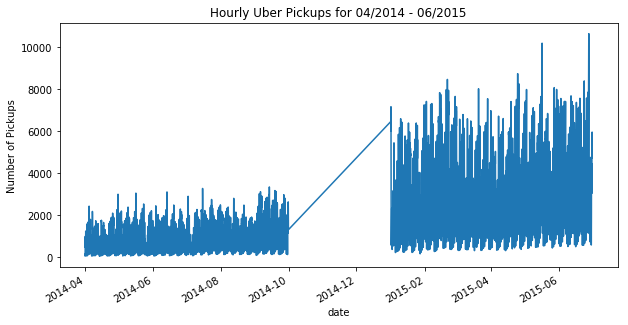

In [122]:
ts_all = pd.concat([ts14, ts15])
ts_all.plot(figsize=(10,5), 
          title='Hourly Uber Pickups for 04/2014 - 06/2015', 
          legend=False)
plt.ylabel('Number of Pickups');

The plot above shows the 2 datasets - 2014 and 2015 - and it's clear that there is a general positive time-dependent trend present.  

However, there is a significant gap in the middle which means it's not possible to use the entire dataset. Next, we can plot 2014 and 2015 separately and pick one to use for the rest of the analysis. 

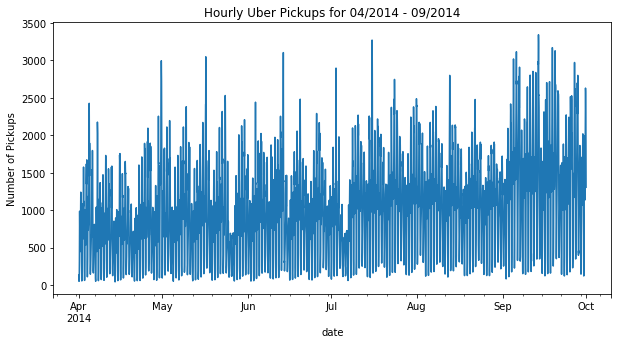

In [56]:
ts14.plot(figsize=(10,5), 
          title='Hourly Uber Pickups for 04/2014 - 09/2014', 
          legend=False)
plt.ylabel('Number of Pickups');

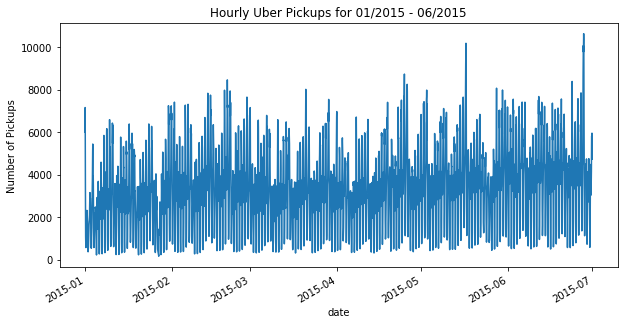

In [20]:
ts15.plot(figsize=(10, 5), 
          title='Hourly Uber Pickups for 01/2015 - 06/2015', 
          legend=False)
plt.ylabel('Number of Pickups');
plt.savefig('2015_data.png', dpi=250)

The following is evident in the 2 plots above:
1. There is a positive time-dependent trend (number of pickups generally increases overall).
2. There are many cyclical effects - the highs and lows show up repeatedly at roughly uniform intervals. 

Further plots of monthly, weekly, and hourly data should make those cyclical effects clear.  

**For the next steps, we'll only use the 2015 data since it's more recent.**

In [ ]:
# delete 2014 dataframe from memory
del ts14

### Split train/test

For 2015, there is data present for 6 months, Jan-June. It is split up as follows:
* **Training set:** January to May (5 months)
* **Test set:** June (1 month)

In [132]:
ts15_train = ts15[:'2015-05'].copy(deep = True)
ts15_test = ts15['2015-06'].copy(deep = True)

In [136]:
del ts15

### Monthly trends

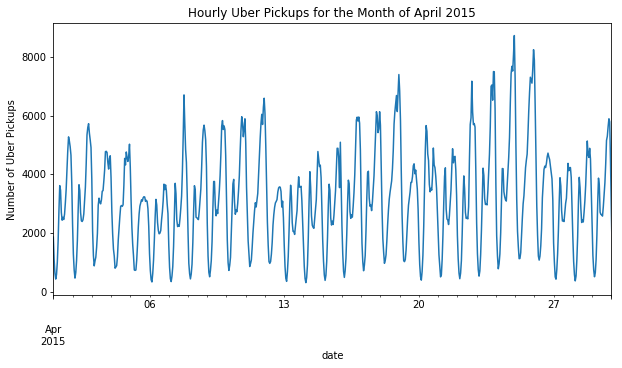

In [138]:
ts15_train['2015-04'].plot(figsize=(10,5), 
     title='Hourly Uber Pickups for the Month of April 2015', 
     legend=False, 
     xlim=('2015-04-1', '2015-04-30'))
plt.ylabel('Number of Uber Pickups');

The chart above shows the number of hourly Uber pickups for April 2015, and a few things are clear:
1. There is a strong cyclic effect from the day of the week.
2. There is also variation for the hour of the day. 
3. Some dates (such as 04/24/15) show a higher usage than surrounding weeks. These values could be outliers, related to weather patterns, holidays, or other extraneous factors.

### Hourly trends

We can look at data for one day pretty easily.

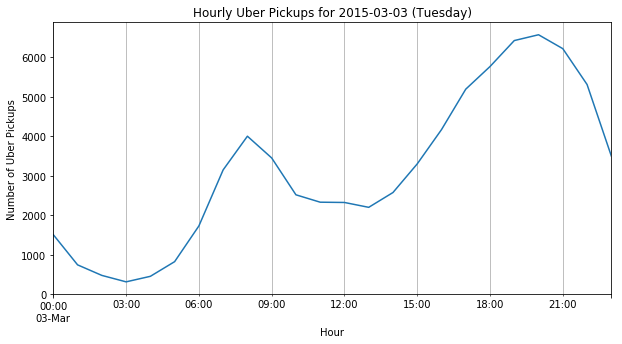

In [139]:
date_str = '2015-03-03' # a random Tuesday date
plot_title = 'Hourly Uber Pickups for {} (Tuesday)'.format(date_str)
ts15_train[date_str].plot(figsize=(10,5),
                    title=plot_title,
                    legend=False,
                    xlim=(ts15_train[date_str].index.min(),
                          ts15_train[date_str].index.max()))
plt.ylabel('Number of Uber Pickups')
plt.xlabel('Hour')
plt.grid(which='minor');

The plot above of a random Tuesday shows the hourly variations we would expect during the morning and evening rush hours. Before drawing any conclusions here, we'll write a function to plot several different days onto the same chart and use that richer plot to draw conclusions.

### Hourly trends (for day of week)

In [140]:
from matplotlib.lines import Line2D

def plot_weekdays(ts):
    """
    - plots # of pickups against days of week.
    - arg `ts` must be a pandas dataframe with a 
      datetime index and values in a column called `pickups`
    """
    # get time range
    min_d = ts.index.date.min()
    max_d = ts.index.date.max()
    title_str = 'Average Hourly Uber Pickups for Day of Week\n'
    title_str = title_str + str(min_d) + ' to ' + str(max_d)
    
    # groupby to create a weekly/hourly count
    ts_w = ts.groupby([ts.index.weekday, ts.index.hour]).mean()
    plt.figure(figsize=(10,5))
        
    for wd in range(0, 7):
        x_vals = ts_w.loc[wd].index
        y_vals = ts_w.loc[wd].pickups
    
        if wd < 5:
            plt.plot(x_vals, y_vals, lw=2, label=wd)
        else:
            plt.plot(x_vals, y_vals, '--', lw=4, label=wd)
        
    plt.legend(['M','Tu','W','Th','F','Sa','Su'], loc=2)
    plt.xlabel('Hour')
    plt.xticks(x_vals, x_vals)
    plt.xlim((0, 23))
    plt.ylim(ymin=0)
    plt.ylabel('Number of Uber Pickups')
    plt.title(title_str)
    plt.grid(True)

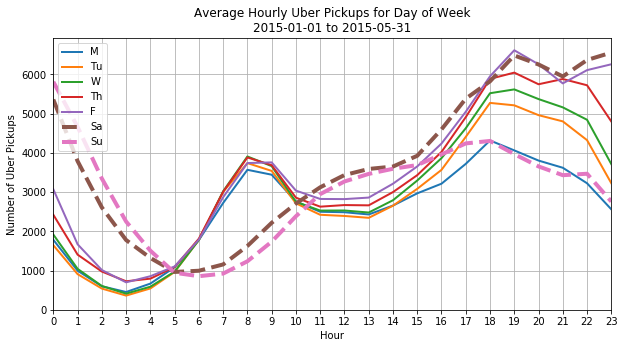

In [141]:
plot_weekdays(ts15_train)

Based on the chart above, which contains all of the 2015 data, we can conclude the following:
1. There is a strong change in the demand for Ubers based on the hour of the day.
2. For weekdays, demand tends to peak during morning and evening rush hours. 
3. For weekends, demand tends to peak in evenings and late nights. 
4. Mondays seem to have the lowest overall demand.
5. Saturdays seem to have the highest overall demand.

## Stationarization

Before we can use this data to forecast the future, we have to test its stationarity. The formula below is taken from [www.analyticsvidhya.com](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) and it plots a rolling mean, standard deviation, and statistics from the Adjusted Dickey-Fuller Test.

In [153]:
# adapted from https://www.analyticsvidhya.com/blog/2016
# /02/time-series-forecasting-codes-python/

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, rolling=24):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window = rolling).mean()
    rolstd = timeseries.rolling(window = rolling).std()

    #Plot rolling statistics:
    plt.figure(figsize=(10,5))
    orig = plt.plot(timeseries, color='darkgray',label='Original')
    mean = plt.plot(rolmean, color='darkblue', label='Rolling Mean', lw=1)
    std = plt.plot(rolstd, color='red', label = 'Rolling Std', lw=1)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel('Differenced # of Uber Pickups\nx(t) - x(t-1)')
    plt.xlim(timeseries.index.min(), timeseries.index.max())
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result = adfuller(timeseries)
    print('> ADF Statistic: {:.3f}'.format(result[0]))
    print('> p-value: {:.3e}'.format(result[1]))
    print('> Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

### Stationarity of raw 2015 training data

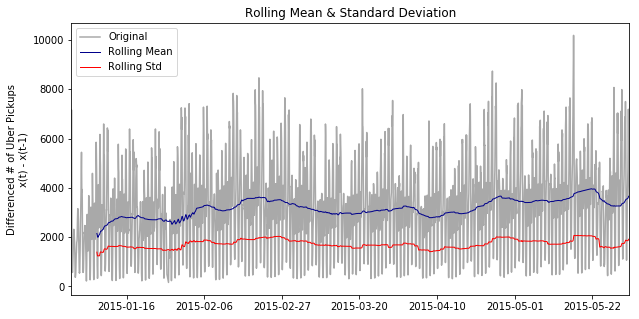

Results of Dickey-Fuller Test:
> ADF Statistic: -5.843
> p-value: 3.734e-07
> Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [154]:
test_stationarity(ts15_train.pickups, rolling=168)

Even with our raw data, we have a significantly negative ADF statistic and near-zero p-value - this means our timeseries is already quite stationary.  

However, we can still move forward with differencing to improve the already high stationarity.

### Differencing the timeseries

#### 1st order differencing

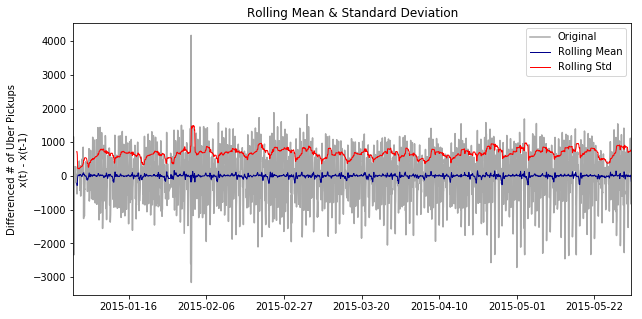

Results of Dickey-Fuller Test:
> ADF Statistic: -15.464
> p-value: 2.681e-28
> Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [529]:
# create a first-order differenced timeseries by
# subtracting the previous hour's value and
# removing the resulting n/a for the first value

diff15 = ts15_train.pickups-ts15_train.pickups.shift(1)
diff15.dropna(inplace=True)

test_stationarity(diff15)

#### 1st order + seasonal differencing  
Since we know from previous plots that our data has a strong cyclical component to it of 1 week, we can try to difference the previous week's data to see if stationarity improves further.

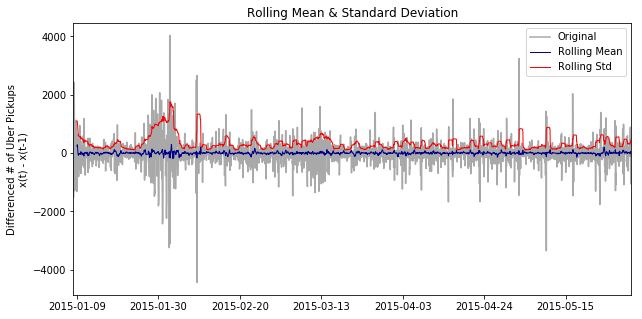

Results of Dickey-Fuller Test:
> ADF Statistic: -17.974
> p-value: 2.790e-30
> Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [533]:
diff15 = diff15-diff15.shift(168)
diff15.dropna(inplace=True)

test_stationarity(diff15)

As the much lower ADF statistic and p-value show, this differenced timeseries is even more stationary than our raw target.

## Auto-Correlation Plots

Number of lags: 72 (3.00 days)


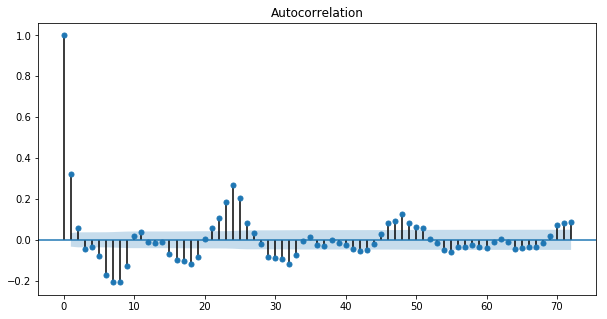

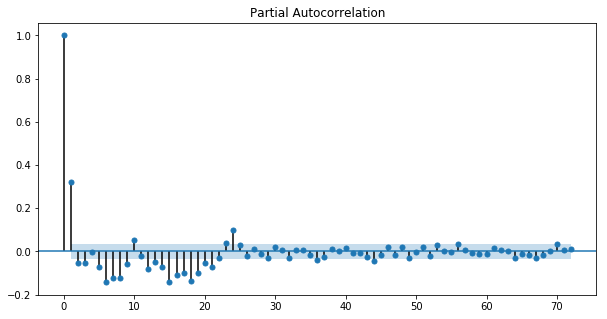

In [539]:
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf

lags_to_show = 72
print('Number of lags: {} ({:.2f} days)'.format(lags_to_show, 
                                                lags_to_show/24))

# plot autocorrelation 
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(diff15, ax = ax, lags=lags_to_show);

# plot PACF
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(diff15, ax = ax, lags=lags_to_show);

Based on the autocorrelation chart above, we'll take the 2nd MA term, since the next few are not very significant. For the AR terms from the partial autocorrelation plot, we'll also take the 2nd term as the next few are not as significant. For our seasonal ARIMA model:  
* p = 2
* d = 1
* q = 1

## Modelling

### Comparison Functions  
We'll use the functions below to plot forecasts from various models and calculate their RMSE errors.

In [732]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_actual, y_predicted, print_val=True):
    """
    Args:
    -----
    y_actual - Array of actual target values
    y_predicted - Array of predicted target values
    print_val - If `True` (default), RMSE will be
                printed. Otherwise, it will be 
                returned.
    """
    err = sqrt(mean_squared_error(y_actual, y_predicted))
    if print_val:
        print('RMSE: {:,.2f}'.format(err))
    else:
        return err
    
    
def plot_forecast(actual, pred, title='Actual vs Forecast', 
                  xlabel='Date', ylabel='Number of Uber Pickups', 
                  grid=True, figsize=(10, 5)):
    
    if len(actual) != len(pred):
        return_str = 'Unequal lengths error: '
        return_str += '({} actual, '.format(len(actual))
        return_str += '{} forecast)'.format(len(pred))
        return return_str
    
    plt.figure(figsize=figsize)
    plt.plot(actual, label='Actual')
    plt.plot(actual.index, pred, label='Predicted', c='r')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(actual.index.date[::24], 
               actual.index.day[::24])
    plt.xlim(min(actual.index.date), max(actual.index.date))
    plt.legend(loc=0)
    plt.grid(True)

### SARIMAX

Typically, we would be able to use a SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) model as a baseline forecaster. However, because of its implementation in statsmodels, it does not perform well for series with very long seasonal lags (168 in this case - 1 week). Therfore, we'll use the seasonal_decompose method to gain additional insights into the timeseries and use a SARIMAX model with a seasonal lag of 24 (1 day) but not optimize it further. 

In [540]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax

<Figure size 432x288 with 0 Axes>

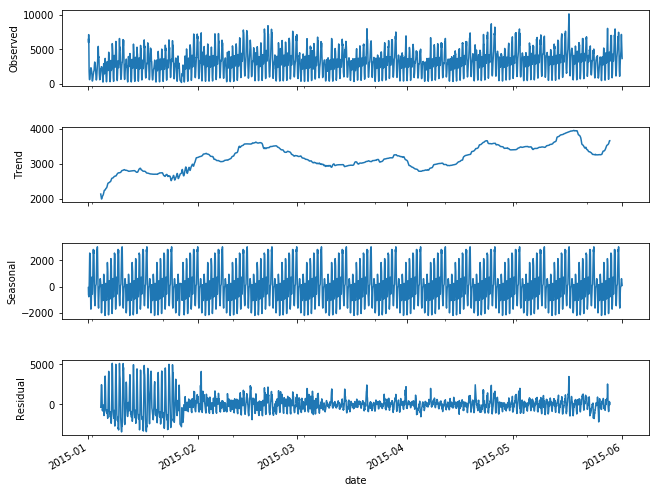

In [612]:
decomposition = seasonal_decompose(ts15_train, freq=168)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10, 8)

In [661]:
# create SARIMAX model with previously determined lags
sar_m = sarimax.SARIMAX(ts15_train.values,
                        trend='n', 
                        order=(2,1,1), 
                        seasonal_order=(2, 1, 1, 24), 
                        simple_differencing=False).fit()

RMSE: 1,053.65


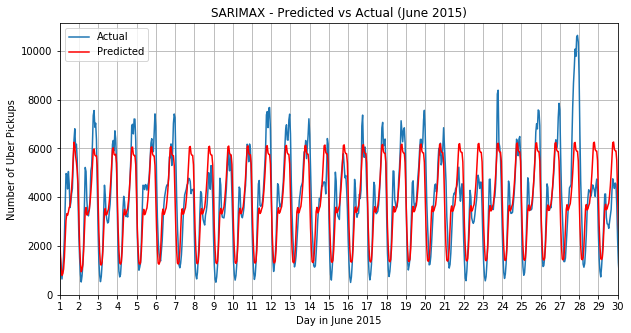

In [734]:
# forecast = results.predict(start = 168, end = 191)
predict_steps = 24*30
forecast = sar_m.forecast(steps=predict_steps)

# plot against real data
plot_forecast(ts15_test[:predict_steps], forecast, 
              title='SARIMAX - Predicted vs Actual (June 2015)', 
              xlabel='Day in June 2015', 
              ylabel='Number of Uber Pickups')

# calculate RMSE error
rmse(ts15_test[:predict_steps].pickups, forecast)

As the forecast above shows, our SARIMAX model with a seasonal lag of 24 (and not 168 as it should be) produces a relatively good baseline result. However, it does not do a good job of differentiating weekday and weekend demand, and misses out on some peaks.  

Next, we'll explore some additional ways to model this timeseries. 

### Time-lagged Linear Regression

We can easily make a linear regression model with features such as:
* day of the week
* weekend or not
* hour of day
* number of days since 1/1/2015

In [793]:
%%capture --no-stdout --no-display

# create copies of dataframes for linear regression
lr15_train = ts15_train.copy(deep=True)
lr15_test = ts15_test.copy(deep=True)

# helper function for one of the features
def time_since_start(date, start='2015-01-01 00:00:00'):
    date_diff = date - pd.to_datetime(start)
    date_float = date_diff/pd.to_timedelta(1, unit='h')
    return date_float

# add timelagged features
for df in [lr15_train, lr15_test]:
    df['day_of_week'] = df.index.weekday
    df['is_weekend'] = df.index.map(lambda x: 1 if x.weekday() > 4 else 0)
    df['hour_of_day'] = df.index.hour
    df['time_since_jan'] = df.index.map(lambda x: time_since_start(x))

# separate into x and y
X_train = lr15_train[['day_of_week', 'is_weekend', 
                      'hour_of_day', 'time_since_jan']]
X_test = lr15_test[['day_of_week', 'is_weekend',
                    'hour_of_day', 'time_since_jan']]
y_train = lr15_train['pickups']
y_test = lr15_test['pickups']

RMSE: 1,324.13


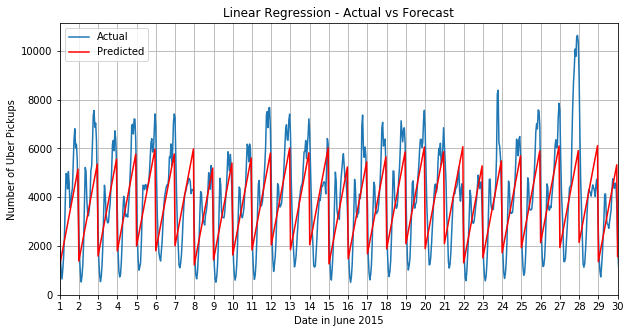

In [794]:
from sklearn.linear_model import LinearRegression

# linear regression
lr = LinearRegression().fit(X_train, y_train)
preds = lr.predict(X_test)

# plot forecast
plot_forecast(y_test, preds, 
              title='Linear Regression - Actual vs Forecast', 
              xlabel='Date in June 2015')

# calculate RMSE error
rmse(y_test, preds)

In [817]:
print('Linear Regression Feature Weights')
print('-'*33)
for i in list(zip(lr.coef_, X_train.columns)):
    print('{:>15}: {:.2f}'.format(i[1], i[0]))

Linear Regression Feature Weights
---------------------------------
    day_of_week: 199.29
     is_weekend: -401.56
    hour_of_day: 172.75
 time_since_jan: 0.27


A simple linear regression does not perform too bad! But yes, it's worse than the previous SARIMAX model based on the RMSE. The feature weights confirm that all features we created were important to the model.  

We will try one more modelling package to see how well it performs.

### Facebook Prophet

For the next model, we'll use Facebook's open source forecasting package named [Prophet](https://facebook.github.io/prophet/). Its method calls are similar to sklearn, when it comes to fitting and predicting. It's a quick way to generate forecasts without too many extraneous features.

#### Fitting

In [818]:
from fbprophet import Prophet

Prophet requires a very specifically named dataframe as input. Instead of modifying our existing timeseries for 2015, we'll create a new one for Prophet.

In [819]:
# creating a new df for prophet test

ts15_prophet = ts15_train.copy(deep=True)
ts15_prophet['ds'] = ts15_prophet.index
ts15_prophet['y'] = ts15_prophet['pickups']
ts15_prophet.reset_index(inplace=True)
ts15_prophet.drop(labels=['date', 'pickups'], axis=1, inplace=True)

In [823]:
%%capture
# fitting df to prophet

m = Prophet(yearly_seasonality=False)
m.fit(ts15_prophet);

In [824]:
future = m.make_future_dataframe(periods=720, freq='H')
forecast = m.predict(future)

#### Forecasting

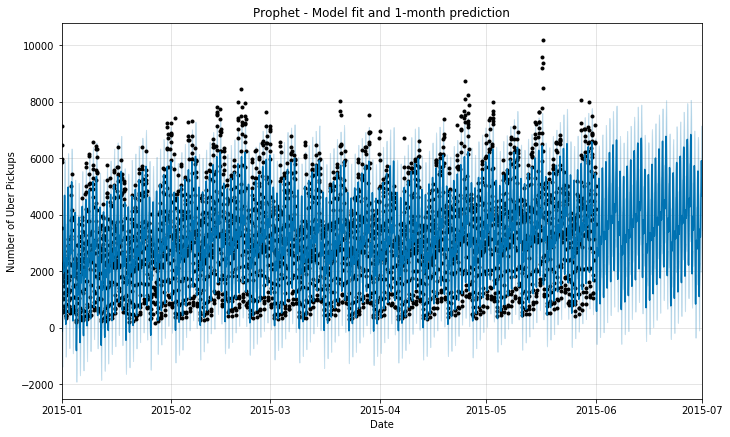

In [825]:
m.plot(forecast, xlabel='Date', ylabel='Number of Uber Pickups')
plt.title('Prophet - Model fit and 1-month prediction')
plt.xlim(('2015-01-01', '2015-07-01'));

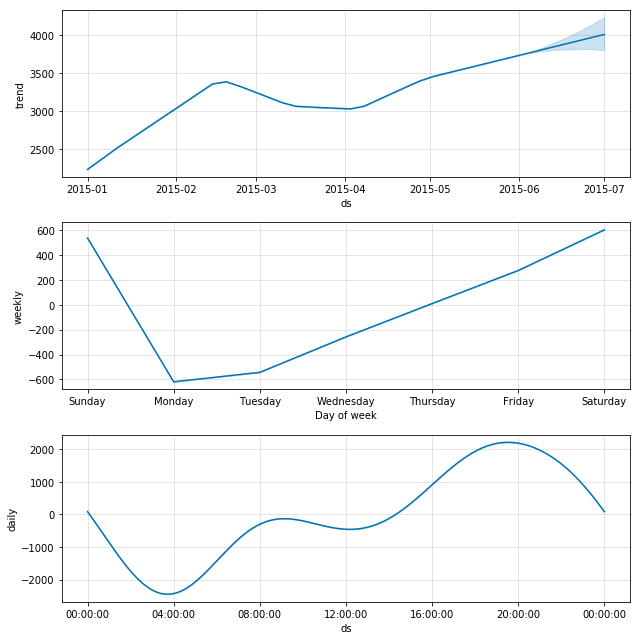

In [826]:
m.plot_components(forecast);

#### Scoring

RMSE: 1,002.15


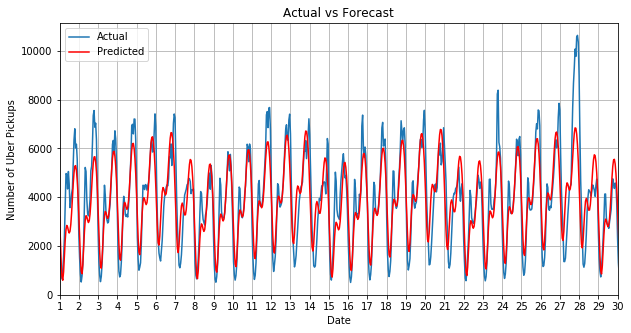

In [829]:
pred = pd.DataFrame(forecast.yhat[-720:])
plot_forecast(ts15_test.pickups, pred)
rmse(ts15_test.pickups, pred)

That's slightly better than our SARIMAX model and much better than the simple linear regression model. Furthermore, prophet supports additional regressors which might improve this even more.  

In the next notebook, we will use Prophet to analyze differences in forecasts between neighborhoods.